### Sample program for grid search of hyper parameters  

#### Import libraries  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from joblib import dump

#### Parameters  

In [2]:
csv_in = 'ai-end2-5.csv'

#### Read CSV file  

In [3]:
df = pd.read_csv(csv_in, delimiter=',', skiprows=0, header=0)
print(df.shape)
print(df.info())
display(df.head())

(506, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   MEDV     506 non-null    float64
 1   CRIM     506 non-null    float64
 2   ZN       506 non-null    float64
 3   INDUS    506 non-null    float64
 4   CHAS     506 non-null    float64
 5   NOX      506 non-null    float64
 6   RM       506 non-null    float64
 7   AGE      506 non-null    float64
 8   DIS      506 non-null    float64
 9   RAD      506 non-null    float64
 10  TAX      506 non-null    float64
 11  PTRATIO  506 non-null    float64
 12  B        506 non-null    float64
 13  LSTAT    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB
None


,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,24.0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,21.6,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,34.7,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,33.4,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,36.2,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


#### Get X and y  

In [4]:
X = df.loc[:, 'CRIM':'LSTAT']  # explanatory variables
y = df['MEDV']  # objective variable
print('X:', X.shape)
display(X.head())
print('y:', y.shape)
print(y.head())

X: (506, 13)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


y: (506,)
0    24.0
1    21.6
2    34.7
3    33.4
4    36.2
Name: MEDV, dtype: float64


#### Make pipeline and set parameters for grid search   

In [5]:
rfr=RandomForestRegressor(random_state=20)            

# Hyperparameter settings for grid search
param_grid = {
    'n_estimators': [50, 100, 500],
    'max_depth' : [4, 6, None],
}

#### Preparation of objects for cross validation  

In [6]:
grid_cv = KFold(n_splits=4, shuffle=True, random_state=21)  # for grid search
gen_cv = KFold(n_splits=4, shuffle=True, random_state=22)  # for estimation of generalization performance

#### Define the grid search for hyperparameters  

In [7]:
gs = GridSearchCV(rfr, param_grid , cv=grid_cv, scoring='neg_mean_squared_error')

#### Estimation of generalization performance  

In [8]:
%%time
nested_score = cross_val_score(gs, X=X, y=y, cv=gen_cv,
                               scoring='neg_mean_squared_error')
print(nested_score)
print(np.sqrt(-nested_score.mean()))

[-14.80570986  -8.79561684  -9.78868283 -10.19374566]
3.300899695207208
CPU times: user 54.4 s, sys: 244 ms, total: 54.7 s
Wall time: 54.7 s


**Generalization performance (RMSE) / 汎化性能 (平均2乗誤差平方根): 0.675**  

#### Cross-validation to obtain the model with the best hyperparameter set (best estimator)  
- Note: gs_best is already fit to the whole data (X) in gs.fit(X, y)  

In [9]:
%%time
gs.fit(X, y)
gs_best = gs.best_estimator_

CPU times: user 13.9 s, sys: 47.7 ms, total: 14 s
Wall time: 14 s


In [14]:
print(gs_best)
for k,v in gs_best.get_params(deep=True).items():
    print(k, '->', v)

RandomForestRegressor(n_estimators=500, random_state=20)
bootstrap -> True
ccp_alpha -> 0.0
criterion -> mse
max_depth -> None
max_features -> auto
max_leaf_nodes -> None
max_samples -> None
min_impurity_decrease -> 0.0
min_impurity_split -> None
min_samples_leaf -> 1
min_samples_split -> 2
min_weight_fraction_leaf -> 0.0
n_estimators -> 500
n_jobs -> None
oob_score -> False
random_state -> 20
verbose -> 0
warm_start -> False


#### Show feature importances of the best model  

In [11]:
print(pd.Series(gs_best.feature_importances_, index=X.columns))

CRIM       0.038219
ZN         0.001114
INDUS      0.006242
CHAS       0.000749
NOX        0.024441
RM         0.429374
AGE        0.013591
DIS        0.066676
RAD        0.003771
TAX        0.013692
PTRATIO    0.016565
B          0.011536
LSTAT      0.374032
dtype: float64


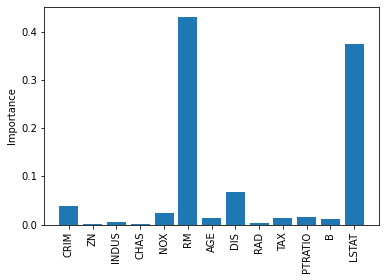

In [12]:
plt.bar(X.columns, gs_best.feature_importances_)
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

**Features (explanatory variable) with the largest importance: alcohol**  
**重要度が最大の説明変数(特徴量): alcohol**  

#### Save the best predictor  

In [13]:
tag = 'wine'
model_file = 'rfr_best_{}.joblib'.format(tag)
dump(gs_best, model_file)

['rfr_best_wine.joblib']